In [ ]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import entropy
from scipy.stats import ks_2samp

%load_ext autoreload
%autoreload 2

In [ ]:
plt.style.use('fivethirtyeight')

import matplotlib as mpl
import matplotlib.pylab as pylab
label_size = 12
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 20
mpl.rcParams['lines.linewidth'] = 3.
mpl.rcParams['grid.linewidth'] = 1.
mpl.rcParams['legend.fontsize'] = label_size
pylab.rcParams['xtick.major.pad']=3
pylab.rcParams['ytick.major.pad']=3

pylab.rcParams['figure.facecolor']='white'
pylab.rcParams['axes.facecolor']='white'
# mpl.rcParams['figure.figsize'] = [12, 10]
# mpl.rcParams.keys()
# Say, "the default sans-serif font is COMIC SANS"
# mpl.rcParams['font.serif'] = 'Times New Roman'
# # Then, "ALWAYS use sans-serif fonts"
# mpl.rcParams['font.family'] = "Serif"

# load results from a directory

In [ ]:
out_dir_main = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/sweep_full_real' # current plots were made with 512

In [ ]:
# depending on how much is saved, this may take a while
out_dir = oj(out_dir_main, folder)
fnames = sorted(os.listdir(out_dir))
results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) if not fname.startswith('weights')]
results = pd.concat(results_list, axis=1).T.infer_objects()

save_dir = 'test'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
# run only once!
results['accs_train'] = np.multiply(results.accs_train, 100/results.batch_size)
results['accs_test'] = np.multiply(results.accs_test, 100/results.batch_size)

In [221]:
results['max_train_acc'] = np.array([max(results.accs_train[i]) for i in range(len(results)) ]) 
results['max_test_acc'] = np.array([max(results.accs_test[i]) for i in range(len(results)) ])

# norm fig
*uses raaz.rsk/track_acts/sweep_full_real' dset*

sgd


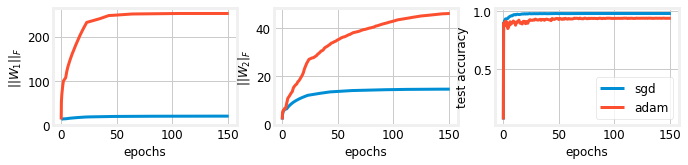

In [225]:
plt.figure(figsize=(10, 2))

rex = results[results['num_layers']==2]
rex = results[results['max_test_acc']>=0.9]

R, C = 1, 3
row_adam = rex.iloc[0]
row_sgd = rex.iloc[3]
print(row_sgd.optimizer)
epochs = sorted(row_sgd['weight_norms'].keys())
fc0 = [row_sgd['weight_norms'][t]['fc.0.weight_fro'] for t in epochs]
fc0_adam = [row_adam['weight_norms'][t]['fc.0.weight_fro'] for t in epochs]
plt.subplot(R, C, 1)
plt.plot(row_sgd.its, fc0)
plt.plot(row_sgd.its, fc0_adam)
plt.xlabel('epochs')
plt.ylabel('$||W_1||_F$')

fc1 = [row_sgd['weight_norms'][t]['fc.1.weight_fro'] for t in epochs]
fc1_adam = [row_adam['weight_norms'][t]['fc.1.weight_fro'] for t in epochs]
plt.subplot(R, C, 2)
plt.plot(row_sgd.its, fc1)
plt.plot(row_adam.its, fc1_adam)
plt.xlabel('epochs')
plt.ylabel('$||W_2|_F$')

plt.subplot(R, C, 3)
plt.plot(row_sgd.its, row_sgd['accs_test'], label=row_sgd['optimizer'])
plt.plot(row_adam.its, row_adam['accs_test'], label=row_adam['optimizer'])
plt.xlabel('epochs')
plt.ylabel('test accuracy')
plt.legend()
plt.show()

In [ ]:
epoch = 151
# r = results[results['num_layers'] == 4]
# N = r.shape[0]
# keys = r['weight_norms']
ts = [0, 1, 151]
# results['fro0_final'] = [results['weight_norms'][i][151]['fc.0.weight_fro'] for i in results.index]
# results['fro1_final'] = [results['weight_norms'][i][151]['fc.1.weight_fro'] for i in results.index]
# results['fro2_final'] = [results['weight_norms'][i][151]['fc.2.weight_fro'] for i in results.index]
# results['fro3_final'] = [results['weight_norms'][i][151]['fc.0.weight_fro'] for i in results.index]

numlays = 2
r = results[results['num_layers']==numlays]
for t in ts:
    for i in range(numlays):
        r['fro' + str(i) + '_' + str(t)] = [r['weight_norms'][j][t]['fc.' + str(i) + '.weight_fro'] for j in r.index]
    r['fros_' + str(t)] = [[r['weight_norms'][j][t]['fc.' + str(i) + '.weight_fro'] for i in range(numlays)] for j in r.index]  

In [ ]:
xw

In [ ]:
R, C = 2, 2
plt.figure(figsize=(8, 8))

rm = r[r['dset'] == 'mnist']
rm = rm[rm['max_test_acc'] > 0.95]
plt.subplot(R, C, 1)
plt.title('mnist')
sns.scatterplot('fro0_final', 'fro1_final', hue='optimizer', data=rm)
plt.plot(range(75))

rc = r[r['dset'] == 'cifar10']
rc = rc[rc['max_test_acc'] > 0.5]
plt.subplot(R, C, 2)
plt.title('cifar10')
sns.scatterplot('max_test_acc','fro0_final', hue='optimizer', data=rc)

# plt.xlim(0, 1000)
plt.show()

In [ ]:
R, C = len(ts), 2
plt.figure(figsize=(8, 8))

for i, t in enumerate(ts):
    plt.subplot(R, C, 1 + i * C)
    for index, row in rm.iterrows():
    #     print(row.keys())
        plt.plot(row['fros_'+str(t)], alpha=0.1, color='red' if row['optimizer']=='adam' else 'cyan')

    plt.subplot(R, C, 2 + i *C)
    for index, row in rc.iterrows():
        plt.plot(row['fros_1'+str(t)], alpha=0.1, color='red' if row['optimizer']=='adam' else 'cyan')

    #     print(row)


In [ ]:
ITS = results.its[0]